In [2]:
from collections import deque, namedtuple
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical
import torch.nn.functional as F
import tqdm
import pickle
import faulthandler

In [44]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [45]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title, smoothing = True, xlabel="Time Steps"):
    """
    Args:
        arr_list (list): List of results arrays to plot
        legend_list (list): List of legends corresponding to each result array
        color_list (list): List of color corresponding to each result array
        ylabel (string): Label of the vertical axis

        Make sure the elements in the arr_list, legend_list, and color_list
        are associated with each other correctly (in the same order).
        Do not forget to change the ylabel for different plots.
    """
    # Set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the vertical labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the standard error (of raw data, not smoothed)
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # Plot the mean
        ma_window_size = 100 if len(arr) > 2000 else 50
        averages = moving_average(arr.mean(axis=0)) if smoothing else arr.mean(axis=0)
        h, = ax.plot(range(arr.shape[1]), averages, color=color, label=legend)
        # Plot the confidence band
        if len(arr_list) <= 2:
            arr_err *= 1.96
            ax.fill_between(range(arr.shape[1]), averages - arr_err, averages + arr_err, alpha=0.3,
                            color=color)
        # Save the plot handle
        h_list.append(h)

    # Plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [46]:
def visualize_stats(experiment_stats, experiment_title, legend='PPO'):
    plot_curves([np.stack(experiment_stats['episode_return'])],
                [legend],
                ['r'],
                xlabel='Episodes',
                ylabel='Discounted return (gamma=0.99)',
                fig_title=f'Training Return, {experiment_title}',
                smoothing=True)

    plot_curves([np.stack(experiment_stats['actor_loss'])],
                [legend],
                ['g'],
                xlabel='Episodes',
                ylabel='Loss',
                fig_title=f'Actor Loss, {experiment_title}',
                smoothing=True)

    plot_curves([np.stack(experiment_stats['critic_loss'])],
                [legend],
                ['b'],
                xlabel='Episodes',
                ylabel='Loss',
                fig_title=f'Critic Loss, {experiment_title}',
                smoothing=True)

    plot_curves([np.stack(experiment_stats['combined_loss'])],
                [legend],
                ['teal'],
                xlabel='Episodes',
                ylabel='Loss',
                fig_title=f'Combined Loss, {experiment_title}',
                smoothing=True)

    plot_curves([np.stack(experiment_stats['episode_length'])],
                [legend],
                ['orange'],
                xlabel='Episodes',
                ylabel='Loss',
                fig_title=f'Episode Lengths, {experiment_title}',
                smoothing=True)

    plot_curves([np.stack(experiment_stats['undiscounted_return'])],
                [legend],
                ['purple'],
                xlabel='Episodes',
                ylabel='Undiscounted return',
                fig_title=f'Undiscounted episode returns, {experiment_title}',
                smoothing=True)

    plot_curves([np.stack(experiment_stats['actor_grad_mag'])],
                [legend],
                ['g'],
                xlabel='Optimizer updates',
                ylabel='Gradient magnitude',
                fig_title=f'Actor Gradient Magnitudes, {experiment_title}',
                smoothing=True)

    plot_curves([np.stack(experiment_stats['critic_grad_mag'])],
                [legend],
                ['b'],
                xlabel='Optimizer updates',
                ylabel='Gradient magnitude',
                fig_title=f'Critic Gradient Magnitudes, {experiment_title}',
                smoothing=True)

    if 'mean_entropy' in experiment_stats:
        plot_curves([np.stack(experiment_stats['mean_entropy'])],
                    [legend],
                    ['tab:orange'],
                    xlabel='Optimizer updates',
                    ylabel='Batch average action entropy',
                    fig_title=f'Mean action distribution entropy over batch of training states, {experiment_title}',
                    smoothing=True)

    if 'entropy_bonus' in experiment_stats:
        plot_curves([np.stack(experiment_stats['entropy_bonus'])],
                    [legend],
                    ['tab:cyan'],
                    xlabel='Optimizer updates',
                    ylabel='Entropy bonus',
                    fig_title=f'Entropy bonus term in actor loss, {experiment_title}',
                    smoothing=True)


In [6]:
def compare_statistic(statistic, experiments_list, legends_list, *args, **kwargs):
    results_arr = [np.stack(ex[statistic]) for ex in experiments_list]
    plot_curves(results_arr,
                legends_list,
                ['r', 'b', 'g', 'orange', 'purple']
                **kwargs)


In [7]:
def save_object(filename, obj):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle)

In [8]:
def load_object(filename):
    with open(filename, 'rb') as handle:
        obj = pickle.load(handle)

    return obj

In [9]:
lunar_stats = load_object('./ppo-ipy-lunar-stats.pkl')

for trial in lunar_stats['entropy_bonus']:
    for step in range(len(trial)):
        trial[step] = trial[step].detach().item()

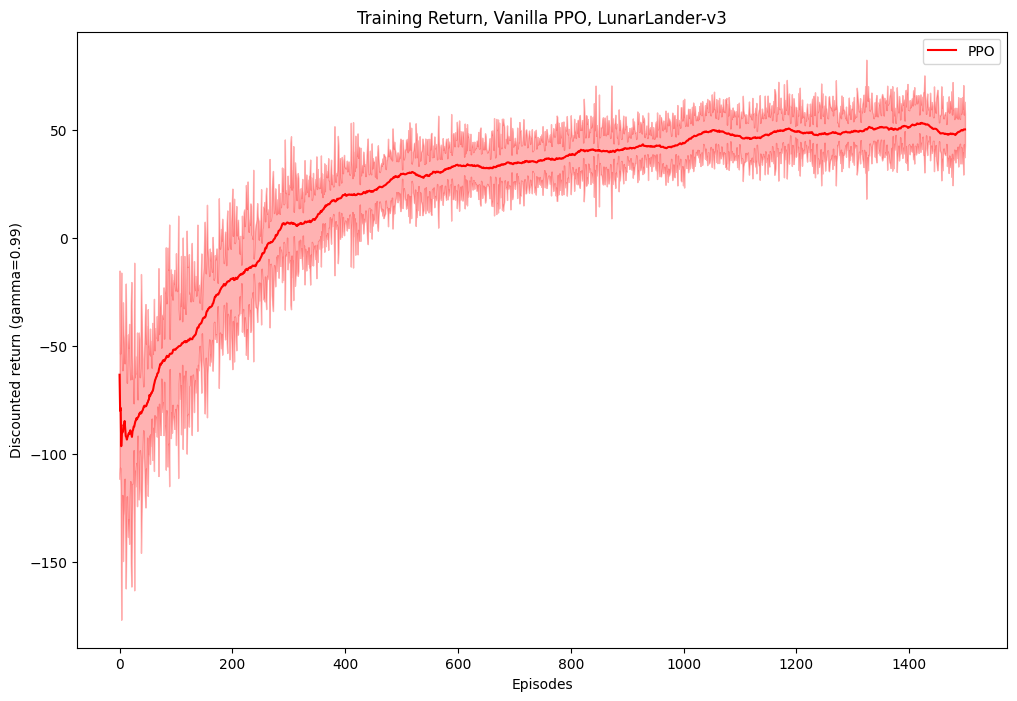

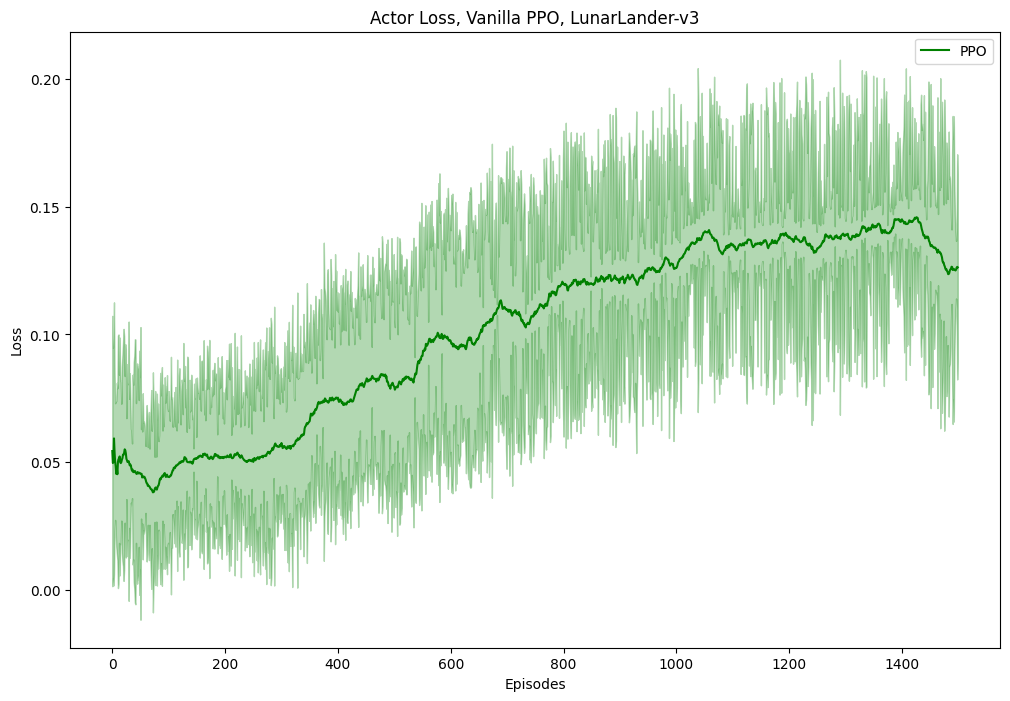

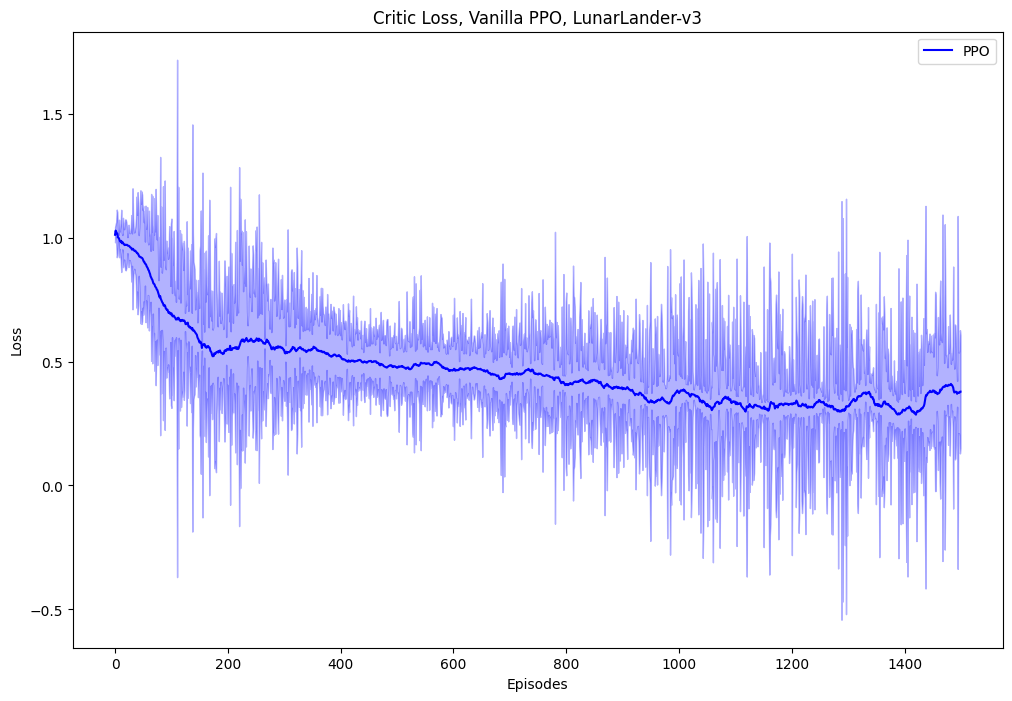

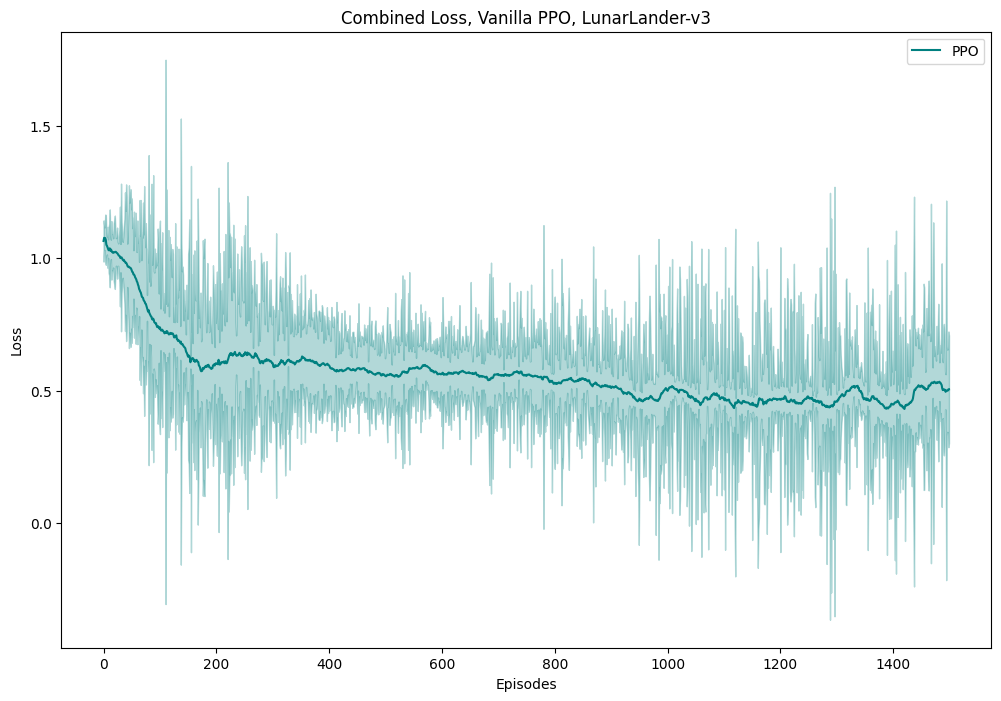

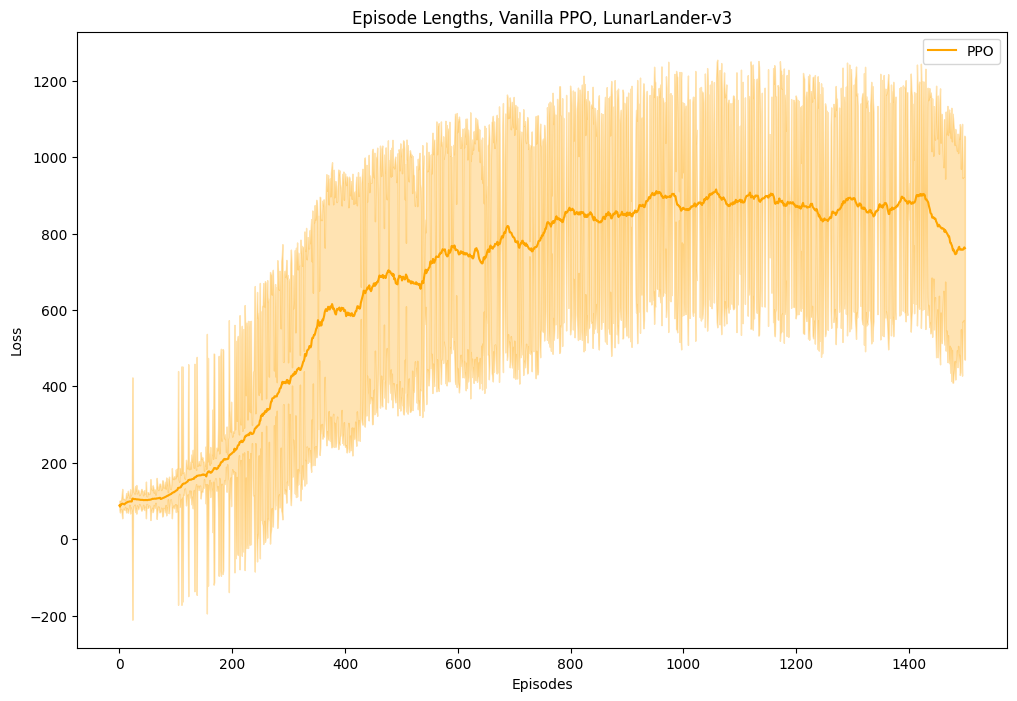

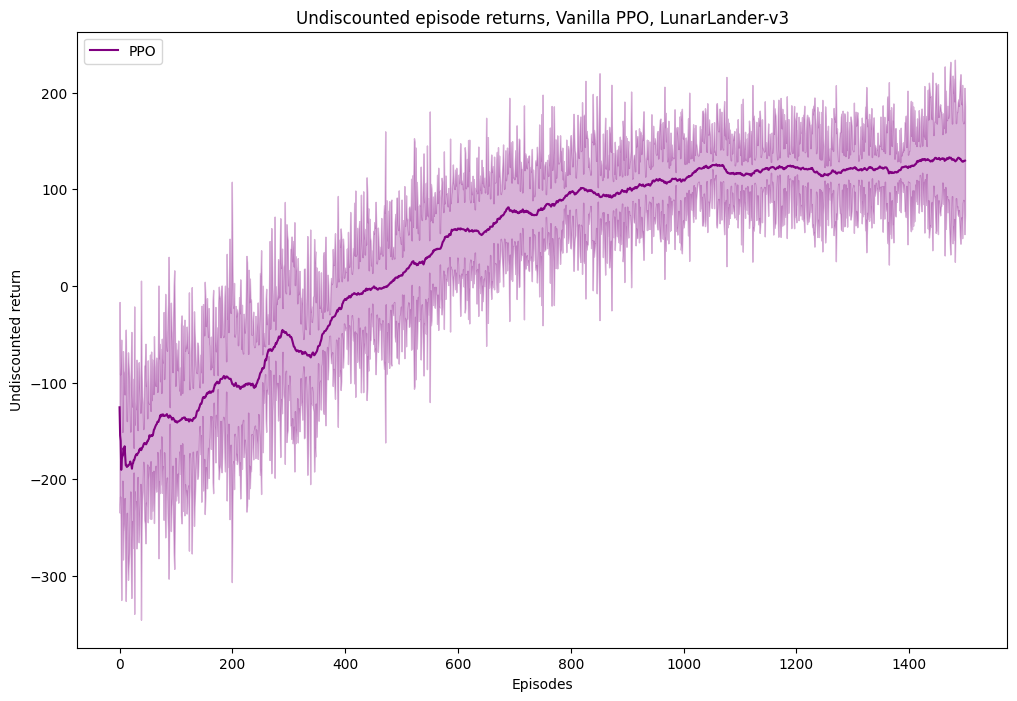

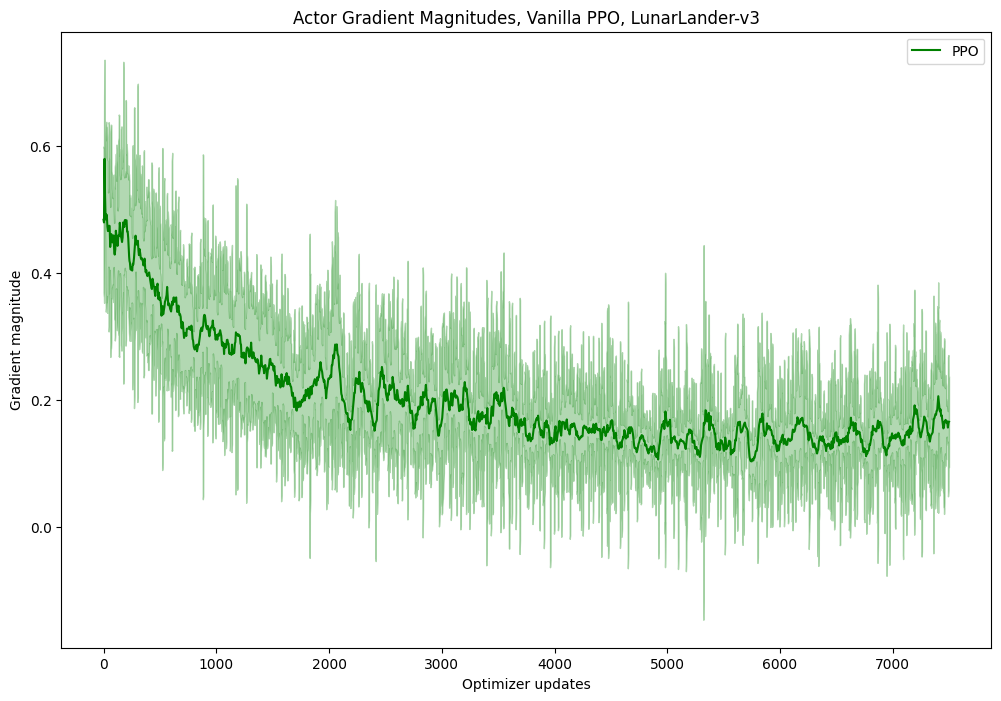

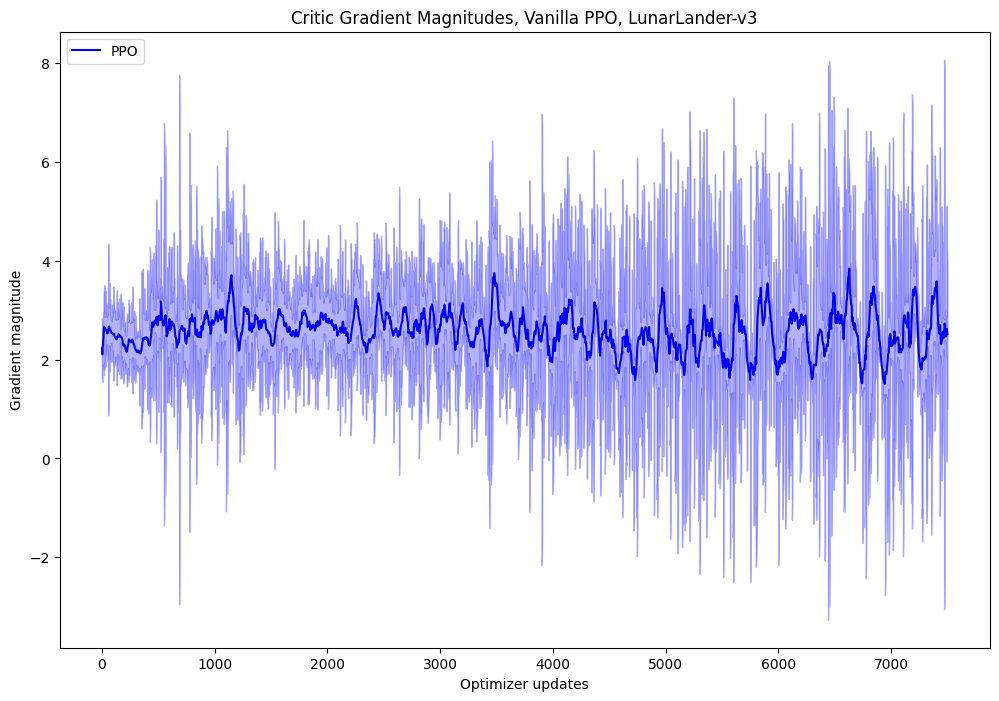

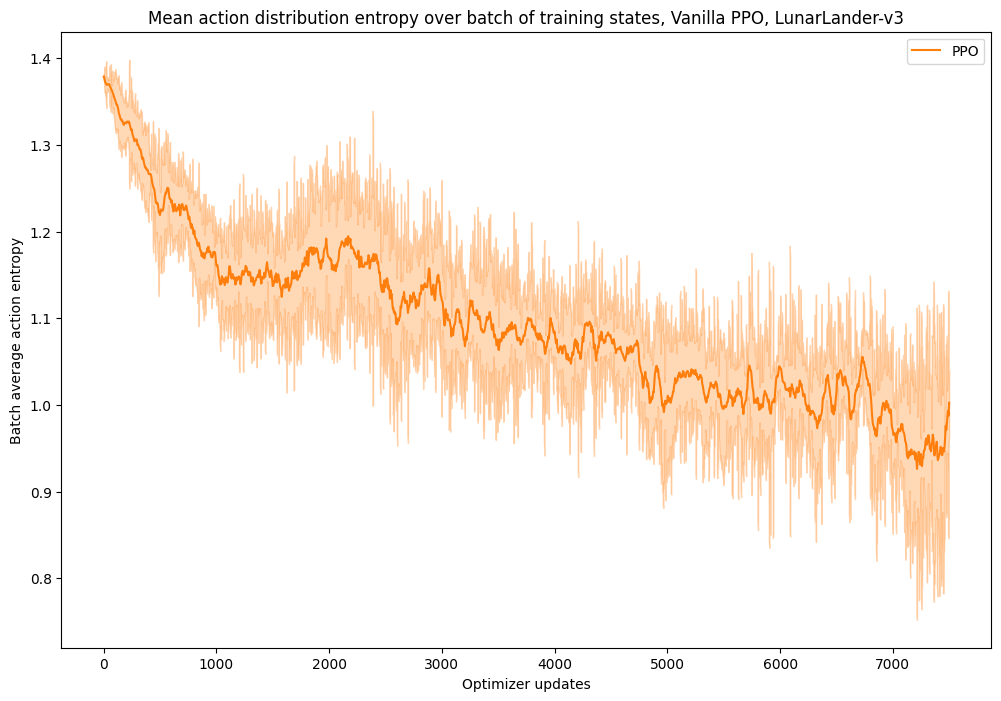

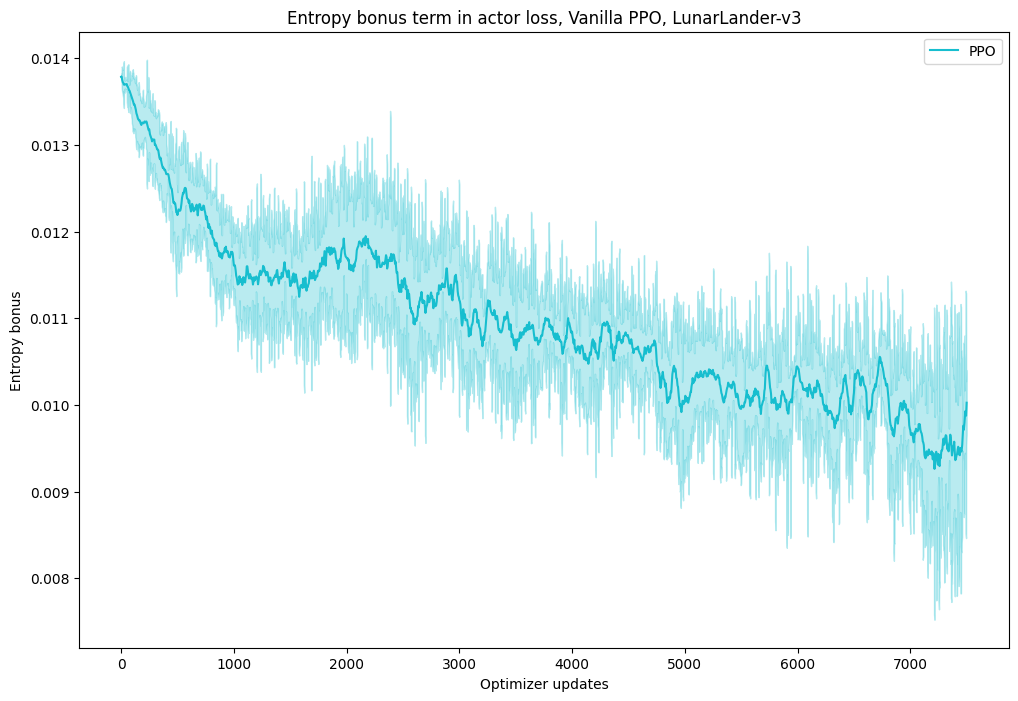

In [47]:
visualize_stats(lunar_stats, 'Vanilla PPO, LunarLander-v3')

In [11]:
lunar_grok_stats = load_object('./ppo-lunar-grok-stats.pkl')

In [13]:
lunar_grade_stats = load_object('./ppo-lunar-grade-stats-v2.pkl')

In [56]:
def visualize_grade_stats(experiment_stats, experiment_title):
    plot_curves([np.stack(experiment_stats['grade.grad_mag_ema']), np.stack(experiment_stats['grade.max_grad_mag_ema'])],
                ['grad_mag_ema', 'max_grad_ema'],
                ['tab:pink', 'tab:cyan'],
                xlabel='Optimizer updates',
                ylabel='Gradient magnitudes',
                fig_title=f'EMA of actor gradient magnitudes (GrAdE), {experiment_title}',
                smoothing=True)

    plot_curves([np.stack(experiment_stats['grade.ema_ratio'])],
                ['ema_ratio'],
                ['tab:purple'],
                xlabel='Optimizer updates',
                ylabel='Scale factor (ema/max_ema)',
                fig_title=f'GrAdE entropy bonus scaling factor, {experiment_title}',
                smoothing=True)

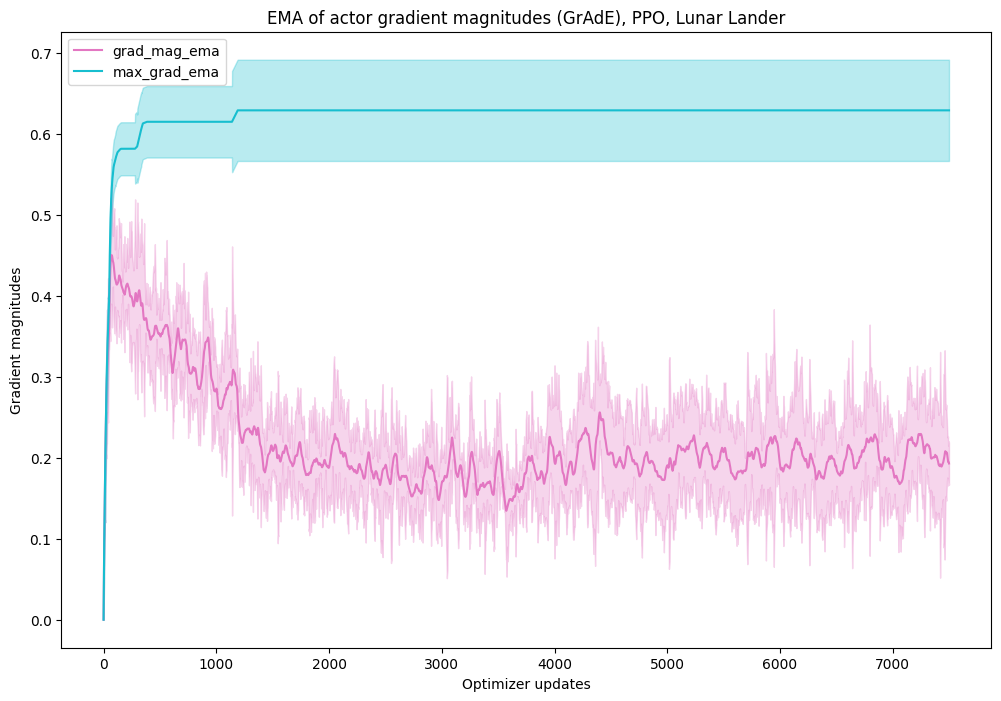

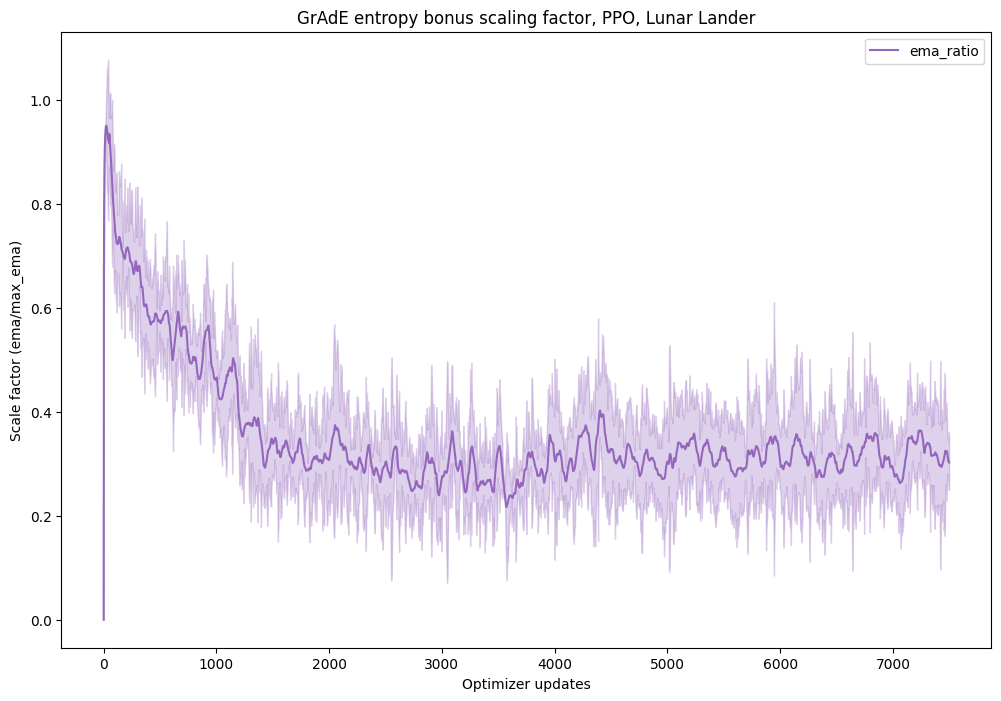

In [57]:
visualize_grade_stats(lunar_grade_stats, 'PPO, Lunar Lander')

In [14]:
lunar_both_stats = load_object('./ppo-lunar-both-stats.pkl')

In [48]:
def make_results_list(experiments_list, statistic):
    return [np.stack(ex[statistic]) for ex in experiments_list]

def compare_all(experiments_list, experiment_title, legends_list):
    keysets = [set(ex.keys()) for ex in experiments_list]
    intersection_keys = keysets[0].intersection(*keysets)
    print(intersection_keys)
    colors_list = ['tab:blue', 'tab:orange', 'tab:red', 'tab:cyan']


    plot_curves(make_results_list(experiments_list, 'episode_return'),
                legends_list,
                colors_list,
                xlabel='Episodes',
                ylabel='Discounted return (gamma=0.99)',
                fig_title=f'Training Return, {experiment_title}',
                smoothing=True)

    plot_curves(make_results_list(experiments_list, 'actor_loss'),
                legends_list,
                colors_list,
                xlabel='Episodes',
                ylabel='Loss',
                fig_title=f'Actor Loss, {experiment_title}',
                smoothing=True)

    plot_curves(make_results_list(experiments_list, 'critic_loss'),
                legends_list,
                colors_list,
                xlabel='Episodes',
                ylabel='Loss',
                fig_title=f'Critic Loss, {experiment_title}',
                smoothing=True)

    plot_curves(make_results_list(experiments_list, 'combined_loss'),
                legends_list,
                colors_list,
                xlabel='Episodes',
                ylabel='Loss',
                fig_title=f'Combined Loss, {experiment_title}',
                smoothing=True)

    plot_curves(make_results_list(experiments_list, 'episode_length'),
                legends_list,
                colors_list,
                xlabel='Episodes',
                ylabel='Loss',
                fig_title=f'Episode Lengths, {experiment_title}',
                smoothing=True)

    plot_curves(make_results_list(experiments_list, 'undiscounted_return'),
                legends_list,
                colors_list,
                xlabel='Episodes',
                ylabel='Undiscounted return',
                fig_title=f'Undiscounted episode returns, {experiment_title}',
                smoothing=True)

    plot_curves(make_results_list(experiments_list, 'actor_grad_mag'),
                legends_list,
                colors_list,
                xlabel='Optimizer updates',
                ylabel='Gradient magnitude',
                fig_title=f'Actor Gradient Magnitudes, {experiment_title}',
                smoothing=True)

    plot_curves(make_results_list(experiments_list, 'critic_grad_mag'),
                legends_list,
                colors_list,
                xlabel='Optimizer updates',
                ylabel='Gradient magnitude',
                fig_title=f'Critic Gradient Magnitudes, {experiment_title}',
                smoothing=True)

{'critic_grad_mag', 'episode_return', 'critic_loss', 'episode_length', 'actor_loss', 'actor_grad_mag', 'undiscounted_return', 'combined_loss'}


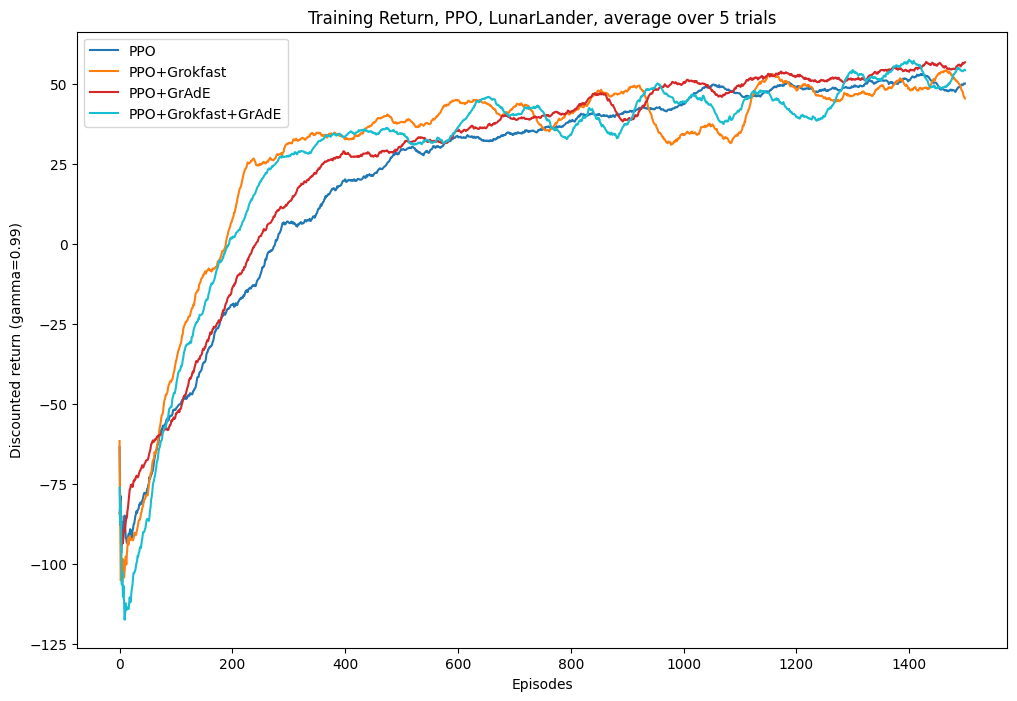

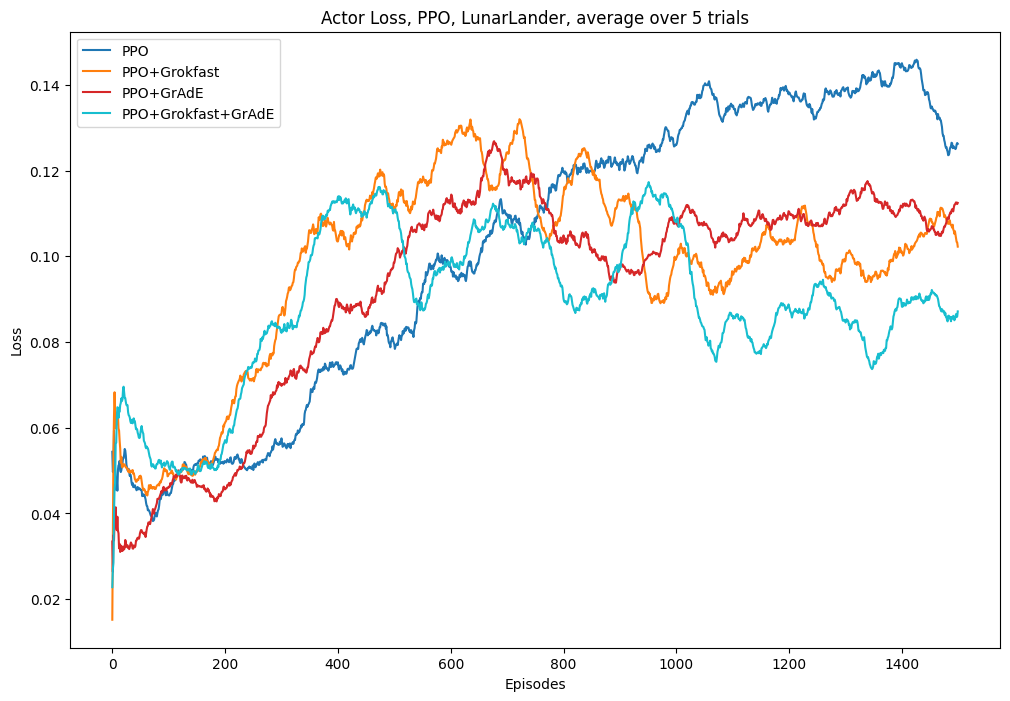

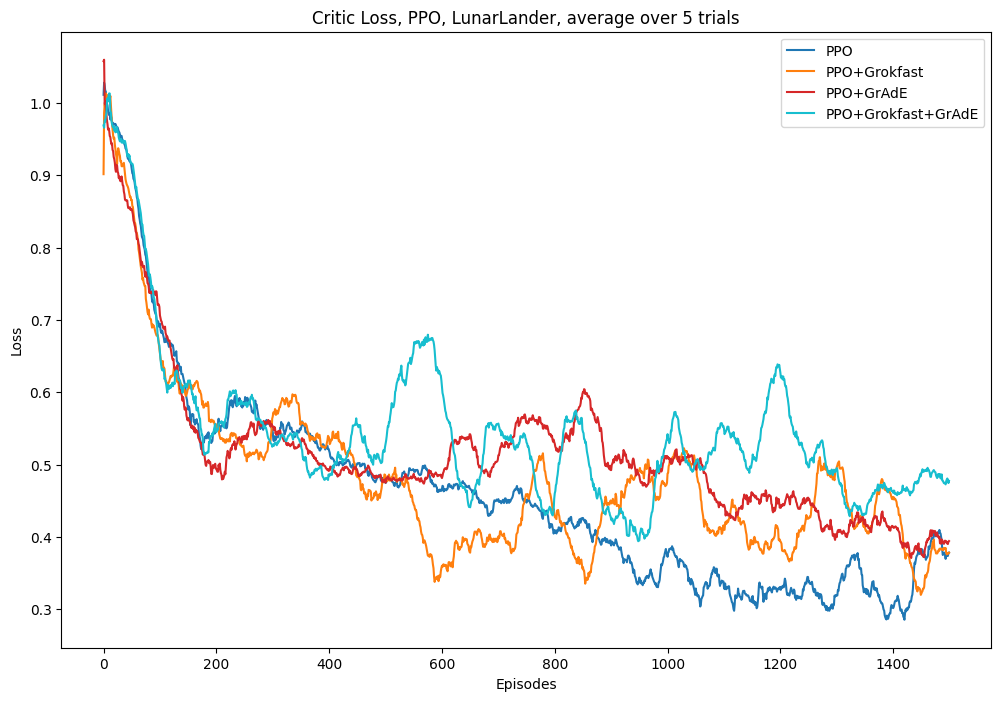

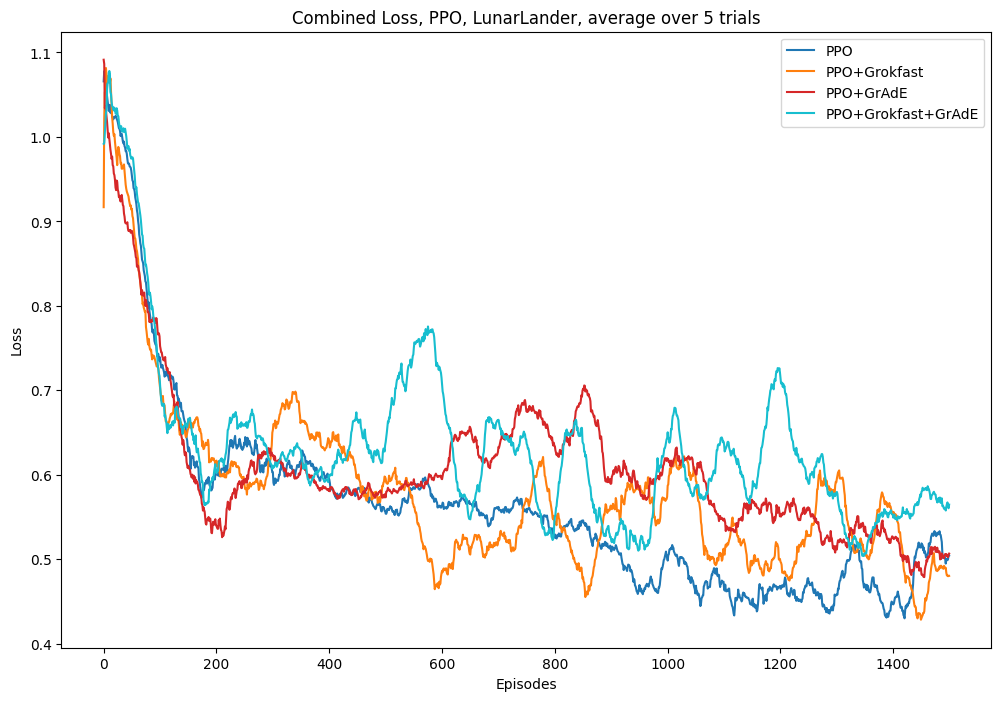

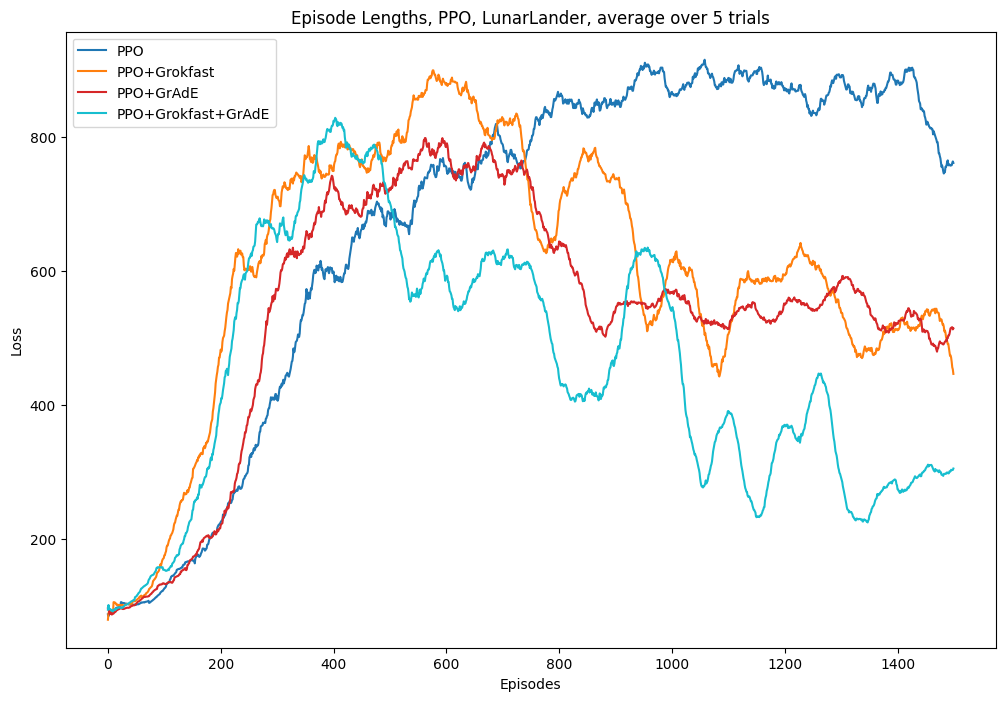

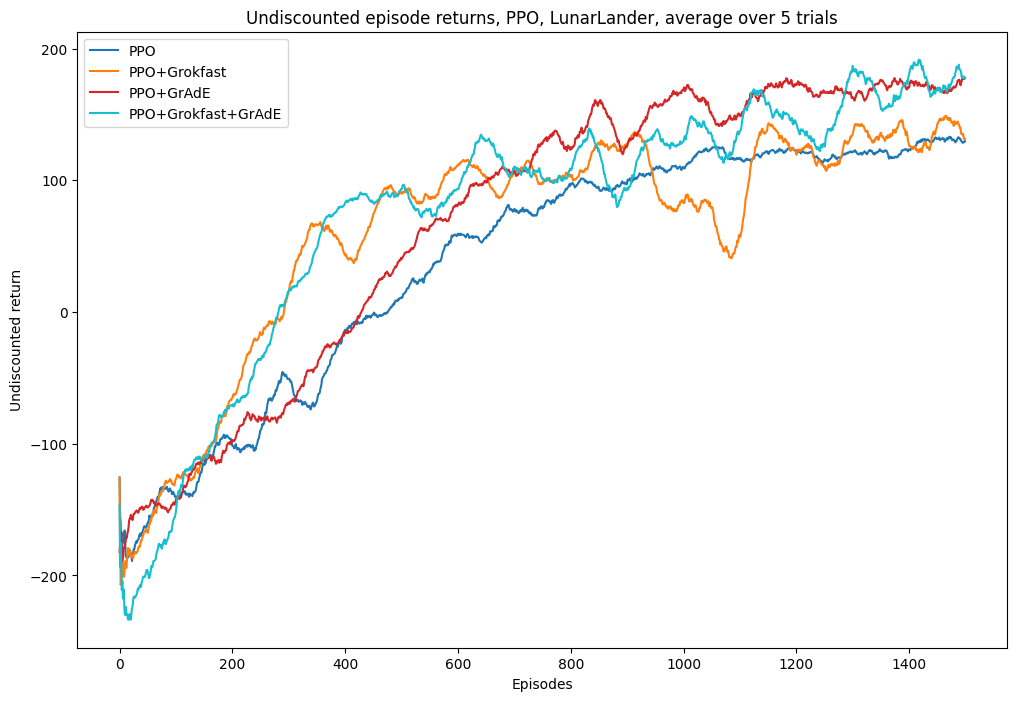

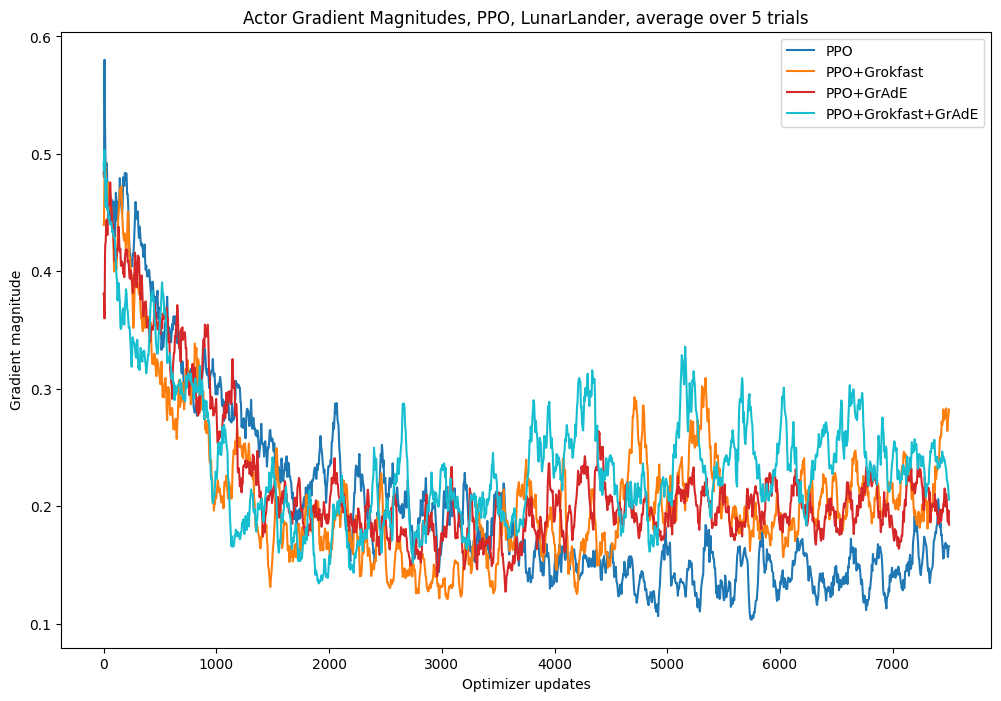

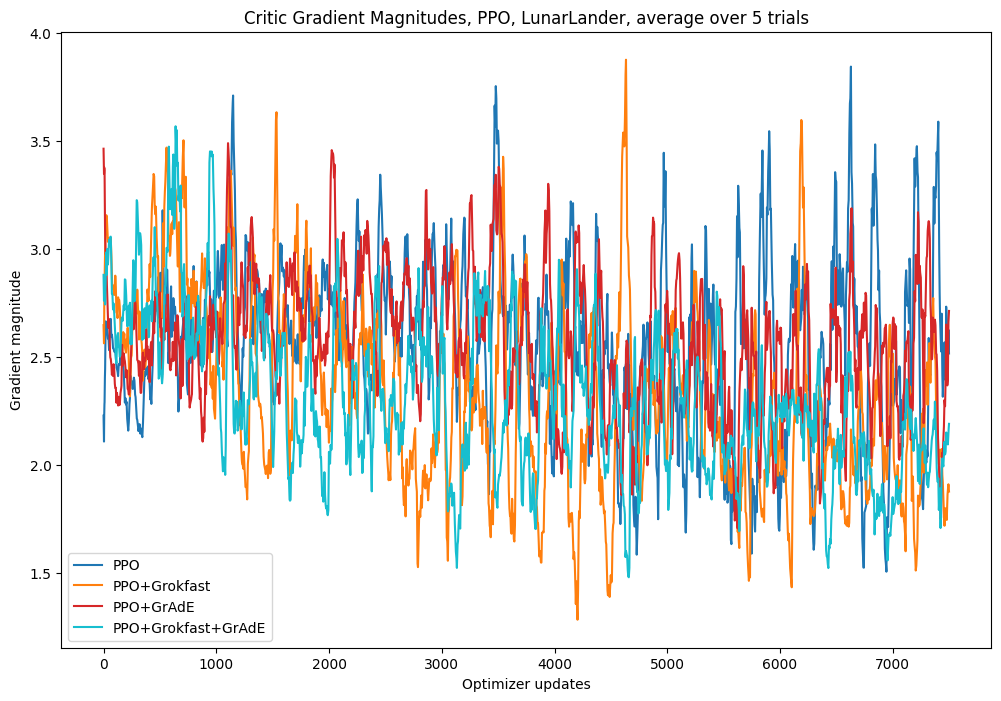

In [49]:
compare_all([lunar_stats, lunar_grok_stats, lunar_grade_stats, lunar_both_stats],
            'PPO, LunarLander, average over 5 trials',
            ['PPO', 'PPO+Grokfast', 'PPO+GrAdE', 'PPO+Grokfast+GrAdE'])

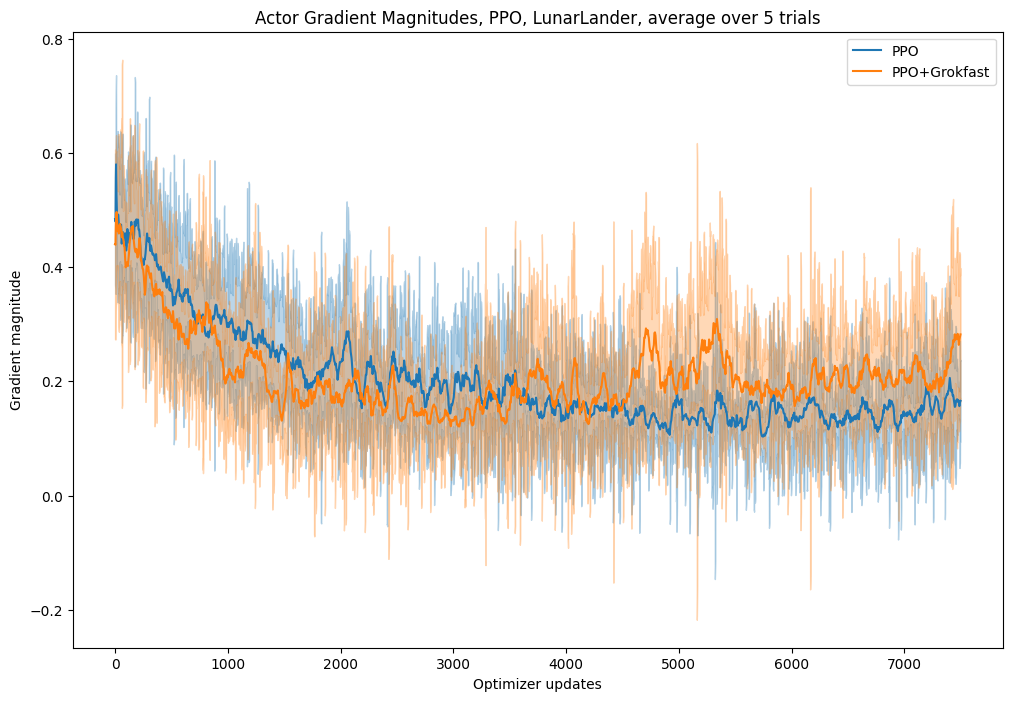

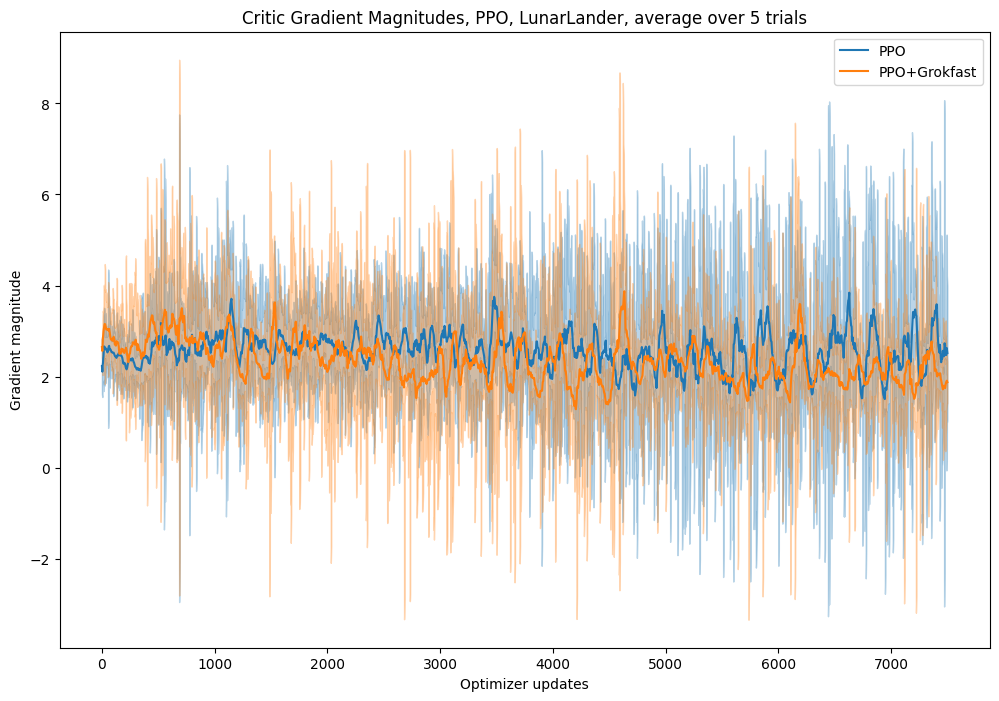

In [52]:
grok_compare = [lunar_stats, lunar_grok_stats]
plot_curves(make_results_list(grok_compare, 'actor_grad_mag'),
                ['PPO', 'PPO+Grokfast'],
                ['tab:blue', 'tab:orange'],
                xlabel='Optimizer updates',
                ylabel='Gradient magnitude',
                fig_title=f'Actor Gradient Magnitudes, PPO, LunarLander, average over 5 trials',
                smoothing=True)

plot_curves(make_results_list(grok_compare, 'critic_grad_mag'),
            ['PPO', 'PPO+Grokfast'],
            ['tab:blue', 'tab:orange'],
            xlabel='Optimizer updates',
            ylabel='Gradient magnitude',
            fig_title=f'Critic Gradient Magnitudes, PPO, LunarLander, average over 5 trials',
            smoothing=True)

In [50]:
print(lunar_grade_stats.keys())

dict_keys(['episode_length', 'episode_return', 'undiscounted_return', 'grade.grad_mag_ema', 'grade.max_grad_mag_ema', 'grade.ema_ratio', 'actor_grad_mag', 'critic_grad_mag', 'mean_entropy', 'entropy_bonus', 'actor_loss', 'critic_loss', 'combined_loss'])


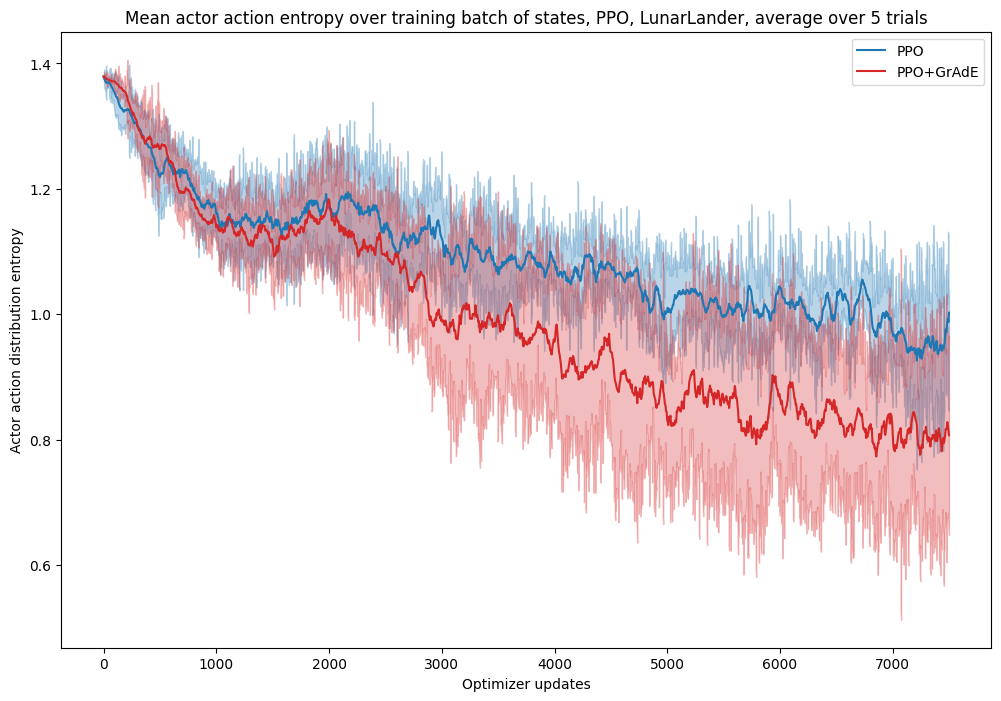

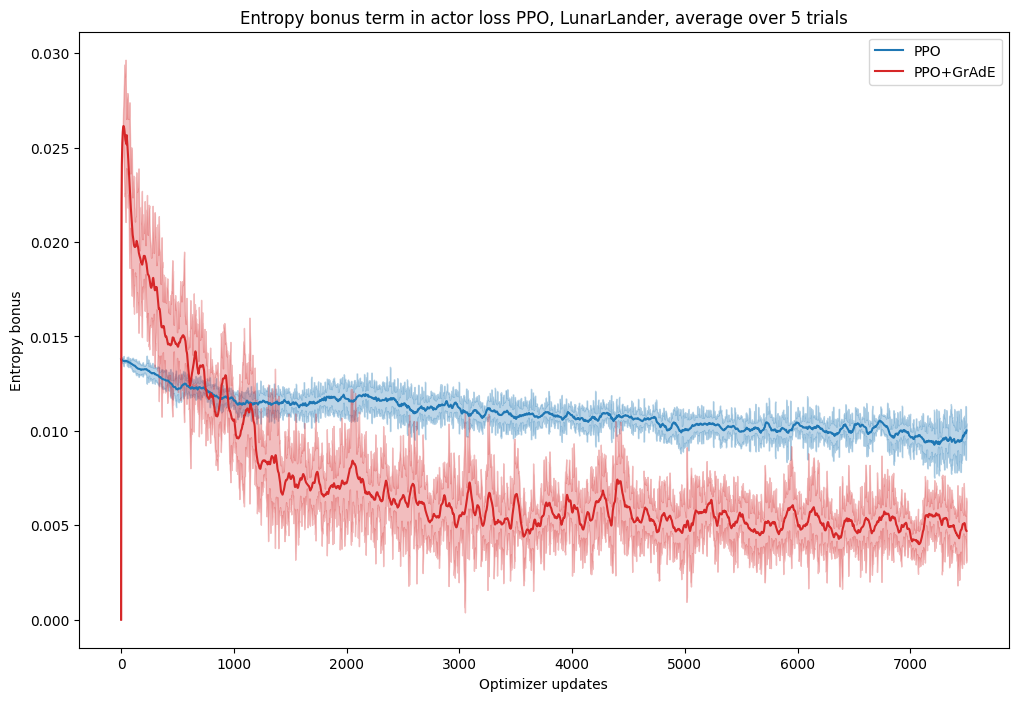

In [55]:
grade_compare = [lunar_stats, lunar_grade_stats]
plot_curves(make_results_list(grade_compare, 'mean_entropy'),
                ['PPO', 'PPO+GrAdE'],
                ['tab:blue', 'tab:red'],
                xlabel='Optimizer updates',
                ylabel='Actor action distribution entropy',
                fig_title=f'Mean actor action entropy over training batch of states, PPO, LunarLander, average over 5 trials',
                smoothing=True)

plot_curves(make_results_list(grade_compare, 'entropy_bonus'),
            ['PPO', 'PPO+GrAdE'],
            ['tab:blue', 'tab:red'],
            xlabel='Optimizer updates',
            ylabel='Entropy bonus',
            fig_title=f'Entropy bonus term in actor loss PPO, LunarLander, average over 5 trials',
            smoothing=True)